In [1]:
####################
# vvvvvvvvvvvvvvvvvvvvvvvvv
STORM_NUMBER = 13
# ^^^^^^^^^^^^^^^^^^^^^^^^^
####################
import datetime
import pytz
from pyiem.plot import MapPlot, nwssnow
import pandas as pd
import numpy as np
from metpy.gridding.interpolation import inverse_distance
from pyiem import iemre, reference
from pyiem.util import get_dbconn, utc
%matplotlib inline
cmap = nwssnow()
clevs = np.array([0.01, 1, 2, 3, 4, 6, 8, 12, 18, 24, 30, 36])

In [2]:
txt = """"""

def get_lsrs(sts, ets):
    ''' Return snowfall lsrs '''
    POSTGIS = get_dbconn('postgis', user='nobody')
    cursor = POSTGIS.cursor()
    data = []
    cursor.execute("""
    SELECT state, max(magnitude) as val, ST_x(geom) as lon, ST_y(geom) as lat
    from lsrs WHERE type in ('S') and magnitude > 0 and 
    valid >= %s and valid < %s and wfo in ('FSD', 'MPX', 'ARX', 'DVN', 'EAX', 'OAX', 'DMX')
    GROUP by state, lon, lat
    """, (sts, ets))
    for i, row in enumerate(cursor):
        data.append(dict(val=row[1], lat=row[3], lon=row[2], label='l%s' % (i,),
                         source='lsr', useme=True))
    
    cursor.close()
    POSTGIS.close()
    return data

def get_coop(dates):
    ''' Return snowfall obs for the given dates '''
    if len(dates) == 1:
        dates.append( dates[0] )
    IEM = get_dbconn('iem', user='nobody')
    cursor = IEM.cursor()
    data = []
    cursor.execute("""
    WITH obs as (
        SELECT s.iemid, count(*), sum(snow) from summary s JOIN stations t on (t.iemid = s.iemid)
        WHERE t.network in ('IACOCORAHS','IA_COOP', 'MN_COOP', 'WI_COOP', 'IL_COOP', 'MO_COOP',
        'KS_COOP', 'NE_COOP', 'SD_COOP') and s.day in """+str(tuple(dates))+""" 
        and snow >= 0 GROUP by s.iemid
    )
    SELECT id, obs.count, obs.sum, ST_x(geom), ST_y(geom), county from stations JOIN obs
    on (obs.iemid = stations.iemid)
    """)
    for row in cursor:
        #if row[1] == 2:
        val = row[2]
        #if row[3] > -93.6 and row[4] > 42:
        #    val = 0
        data.append(dict(val=val, lat=row[4], lon=row[3], label=row[0], source='coop', useme=False))
    
    cursor.close()
    IEM.close()
    return data

crows = get_coop( ['2018-02-09', '2018-02-10'] )
sts = utc(2018, 2, 9, 0)
ets = utc(2018, 2, 9, 18, 0)
lrows = get_lsrs(sts, ets)

prows = []
for line in txt.split("\n"):
    if line.strip() == "" or line[0] == ".":
        continue
    val = float(line[29:33])
    label = line[:25].strip()
    lon = 0 - float(line[62:67])
    lat = float(line[55:60])
    prows.append(dict(val=val,lat=lat,lon=lon,label=label,source='pns',useme=False))
    
df = pd.DataFrame(crows + lrows + prows)
df.sort_values(by='val', ascending=False, inplace=True)

In [3]:
# Now we filter the DataFrame
radii = [0.3, 0.6, 0.9]  # decimal degrees

df['useme'] = False
newrows = []
for lon in np.arange(reference.IA_WEST - 2, reference.IA_EAST + 2, radii[0]):
    for lat in np.arange(reference.IA_SOUTH - 2, reference.IA_NORTH + 2, radii[0]):
        hit = False
        for radius in radii:
            west = lon - (radius / 2.)
            east = lon + (radius / 2.)
            south = lat - (radius / 2.)
            north = lat + (radius / 2.)
            df2 = df[(df['lat'] >= south) & (df['lat'] < north) &
                     (df['lon'] >= west) & (df['lon'] < east)]
            if len(df2.index) > 0:
                df.at[df2.index, 'useme'] = False
                df.at[df2.index[0], 'useme'] = True
                hit = True
                break
        if not hit:
            newrows.append(dict(val=0, lat=lat, lon=lon, label='i%s' % (len(newrows),), source='int', useme=True))
            continue
if len(newrows) > 0:
    df = df.append(newrows)
df.set_index('label', inplace=True)

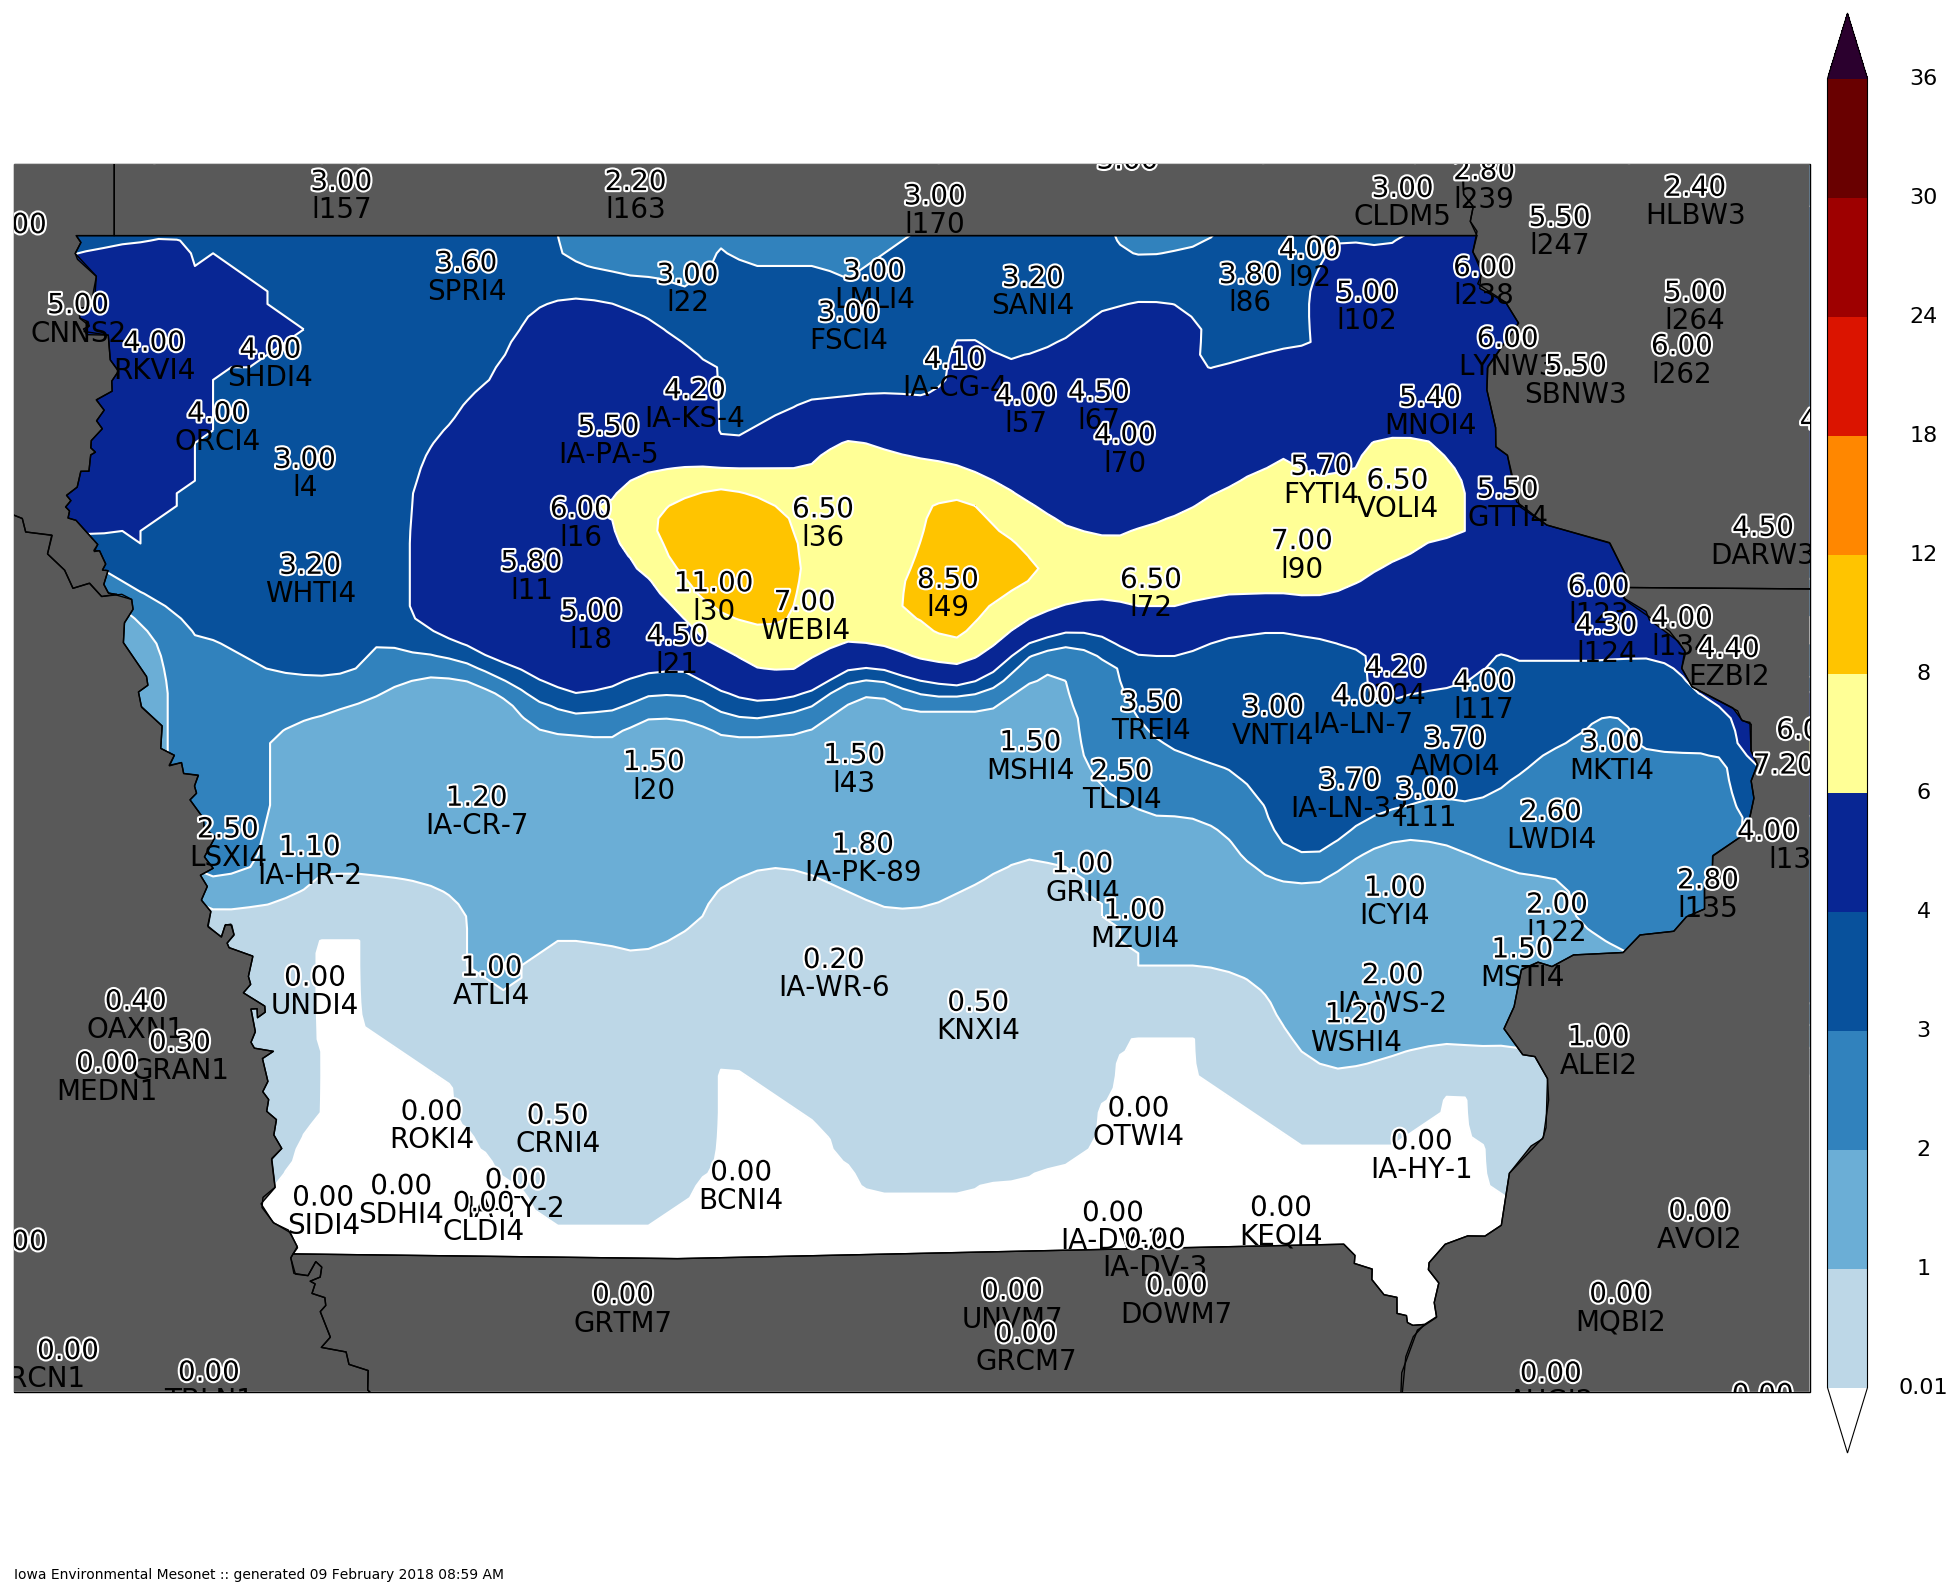

In [10]:
cull = ['IA-KK-3', 'l26', 'OSEI4', 'l84', 'l179', 'l9', 'l56']
if cull:
    df.at[cull, 'useme'] = False

df.at['l20', 'val'] = 1.5
df2 = df[df.useme]


#xi, yi = np.meshgrid(iemre.XAXIS, iemre.YAXIS)
#grid = inverse_distance(df2['lon'].values, df2['lat'].values,
#                            df2['val'].values, xi, yi, 0.5)

m = MapPlot(state='IA', sector='state', figsize=(20,18))
#m.contourf(xi, yi, grid, clevs, cmap=cmap)
vals = m.contourf(df2.lon.values, df2.lat.values, df2.val.values, clevs, cmap=cmap)
np.save("1718_%s.npy" % (STORM_NUMBER, ), vals)
m.plot_values(df2['lon'], df2['lat'], df2['val'], '%.2f', labels=df2.index.values, textsize=20,
              labeltextsize=20, labelbuffer=0)

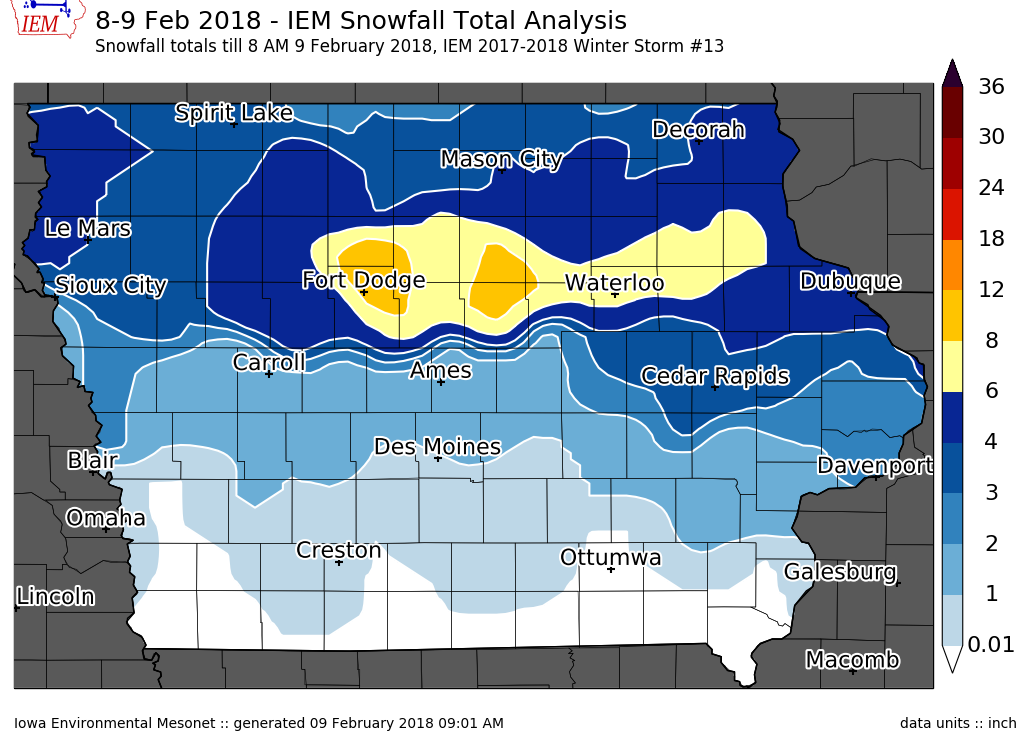

In [12]:
# now we are ready to plot!

m = MapPlot(sector='iowa',
            title='8-9 Feb 2018 - IEM Snowfall Total Analysis',
            subtitle=("Snowfall totals till 8 AM 9 February 2018, "
                      "IEM 2017-2018 Winter Storm #%s") % (STORM_NUMBER, ))
m.contourf(df2.lon.values, df2.lat.values, df2.val.values, clevs, cmap=cmap,
          units='inch')
#m.plot_values(np.array(df2.lon), np.array(df2.lat), np.array(df2.val), '%.2f')
m.drawcounties()
m.drawcities()
m.postprocess(filename='180209.png')

